# Regressorion with Orbit - Advance II

Continue from demo I, we revisit the regression from with multivariate regressors and observe the limit of each regression penalty.

In [1]:
import pandas as pd
import numpy as np
import gc

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

from orbit.dlt import DLT
from orbit.lgt import LGT

from orbit.utils.plot import plot_posterior_params
from orbit.constants.palette import QualitativePalette
from orbit.utils.simulation import make_ts_multiplicative

In [2]:
# randomization is using numpy with this version
print(np.__version__)

1.18.2


## Simulation of Regression with Trend

This time, we simulate regressor in a `multivariate normal` such that our observed values of regressors happen with covariance structure.

In [3]:
# To scale regressor values in a nicer way
REG_BASE = 1000
COEFS = np.array([0.03, 0.08, -0.3, 0.35, 0.22], dtype=np.float64)
SEED = 2020
COVAR = np.array([[0.2, 0.3, 0.0, 0.0, 0.0], 
                 [0.3, 0.2, 0.4, 0.0, 0.0], 
                 [0.0, 0.4, 0.2, 0.0, 0.0], 
                 [0.0, 0.0, 0.0, 0.2, 0.1], 
                 [0.0, 0.0, 0.0, 0.1, 0.2]], dtype=np.float64)

In [4]:
# Looks like the RuntimeWarning is not impactful
raw_df, trend, seas, coefs = make_ts_multiplicative(
    series_len=200, seasonality=52, coefs=COEFS,
    regressor_log_loc=0.0, noise_to_signal_ratio=1.0, 
    regressor_log_cov=COVAR,
    regression_sparsity=0.5, obs_val_base=1000, regresspr_val_base=REG_BASE, trend_type='rw',
    seas_scale=.05, response_col='response', seed=SEED
)
num_of_regressors = len(coefs)
coefs

array([ 0.03,  0.08, -0.3 ,  0.35,  0.22])

## Estimating Coefficients I - full relevance

Assume we observe the data frame `df` and the scaler `REG_BASE`

In [5]:
df = raw_df.copy()
regressor_cols = [f"regressor_{x}" for x in range(1, num_of_regressors + 1)]
response_col = "response"
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [6]:
mod_auto_ridge = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    infer_method='mcmc',
    is_multiplicative=False,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_auto_ridge.fit(df=df)

In [7]:
mod_fixed_ridge1 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    infer_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.5] * num_of_regressors,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

In [8]:
mod_fixed_ridge2 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    infer_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.05] * num_of_regressors,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

In [9]:
coef_auto_ridge = np.median(mod_auto_ridge.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2.posterior_samples['rr_beta'], axis=0)

Small `sigma_prior` may lead to over-regularize.

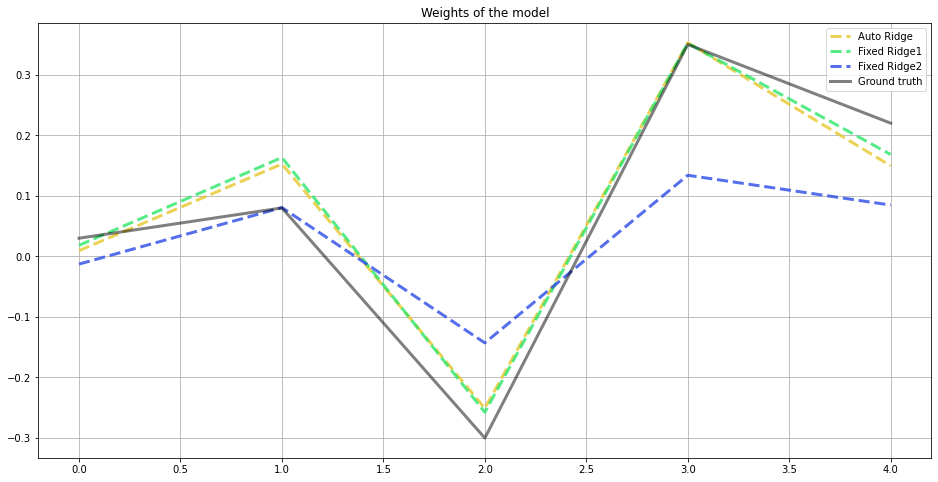

In [10]:
lw=3
plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[0], linewidth=lw, label="Auto Ridge", alpha=0.8, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Fixed Ridge1", alpha=0.8, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge2", alpha=0.8, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth", alpha=0.5)
plt.legend()
plt.grid()

In [11]:
scale_priors = np.round(np.arange(0.05, 0.5 + 0.01, 0.05), 2)
print(scale_priors)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [12]:
coef_sum_list = []
for idx, scale_prior in enumerate(scale_priors):
    print(f"Fitting with scale prior: {scale_prior}")
    # fit a fixed ridge
    mod = DLT(
        response_col=response_col,
        date_col="date",
        regressor_col=regressor_cols,
        seasonality=52,
        seed=SEED,
        predict_method='median',
        infer_method='mcmc',
        is_multiplicative=False,
        regression_penalty='fixed_ridge',
        regressor_sigma_prior=[scale_prior] * num_of_regressors,
        num_sample=1000,
        num_warmup=4000,
    )
    mod.fit(df=df)
    temp = mod.get_regression_coefs()
    temp['scale_prior'] = scale_prior
    temp.rename(columns={'coefficient': 'fixed_ridge_estimate'}, inplace=True)
    temp.drop(['regressor_sign'], inplace=True, axis=1)
    # fit a auto ridge
    mod = DLT(
        response_col=response_col,
        date_col="date",
        regressor_col=regressor_cols,
        seasonality=52,
        seed=SEED,
        predict_method='median',
        infer_method='mcmc',
        is_multiplicative=False,
        regression_penalty='auto_ridge',
        auto_ridge_scale=scale_prior,
        regressor_sigma_prior=[scale_prior] * num_of_regressors,
        num_sample=1000,
        num_warmup=4000,
        stan_mcmc_control={'adapt_delta':0.9},
    )
    mod.fit(df=df)
    temp2 = mod.get_regression_coefs()
    temp['auto_ridge_estimate'] = temp2['coefficient'].values
    coef_sum_list.append(temp)
coef_summary = pd.concat(coef_sum_list, axis=0)
del temp, coef_sum_list
gc.collect()

Fitting with scale prior: 0.05


Fitting with scale prior: 0.1


Fitting with scale prior: 0.15


Fitting with scale prior: 0.2


Fitting with scale prior: 0.25


Fitting with scale prior: 0.3


Fitting with scale prior: 0.35


Fitting with scale prior: 0.4


Fitting with scale prior: 0.45


Fitting with scale prior: 0.5


3460

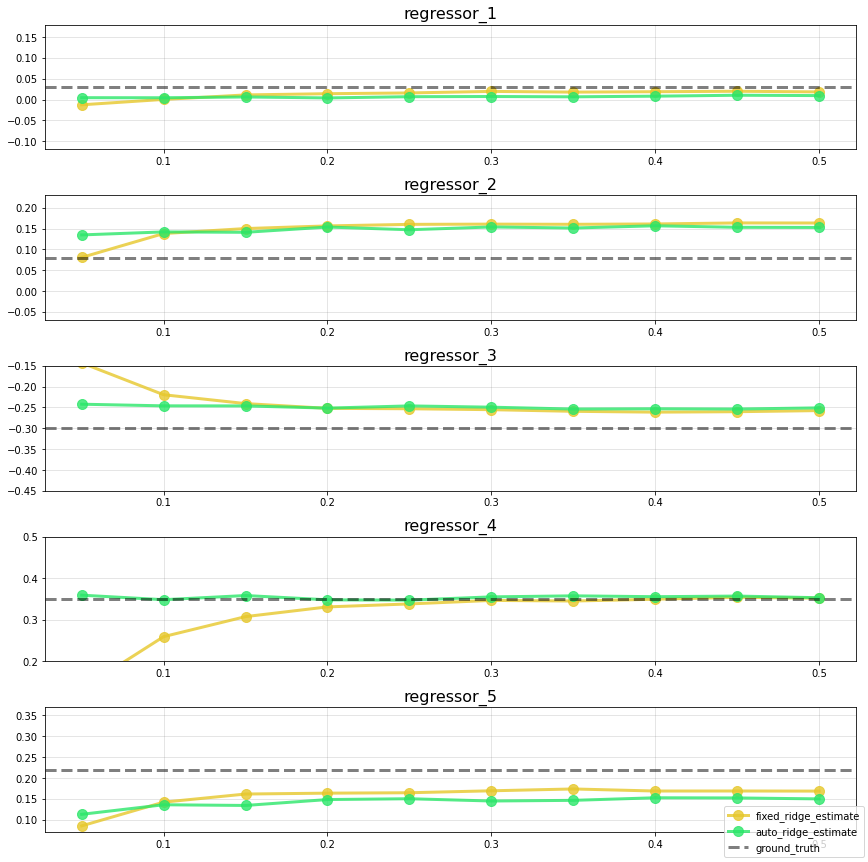

In [13]:
figsize=(12, 12)
fig, axes = plt.subplots(len(regressor_cols), 1, facecolor='w', figsize=figsize)
idx = 0
lw=3
# for idx, reg in enumerate(regressor_cols):
for ax, reg in zip(axes, regressor_cols):

    sub_df = coef_summary[coef_summary['regressor'] == reg]
    x = sub_df['scale_prior'].values
    y = sub_df['fixed_ridge_estimate'].values
    ax.plot(x, y, marker='.', color=QualitativePalette.Line4.value[0], label="fixed_ridge_estimate", 
            lw=lw, markersize=20, alpha=0.8)
    y = sub_df['auto_ridge_estimate'].values
    ax.plot(x, y, marker='.', color=QualitativePalette.Line4.value[1], label="auto_ridge_estimate", 
            lw=lw, markersize=20, alpha=0.8)
 
    ax.axhline(y=coefs[idx], marker=None, color='black', label='ground_truth', lw=lw, alpha=0.5,  linestyle='--')
    ax.grid(True, which='both', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_title(reg, fontsize=16)
    ax.set_ylim(coefs[idx] - 0.15, coefs[idx] + 0.15)
    idx += 1

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
fig.tight_layout()

Using `auto_ridge` would give more stable estimation where user has less worry about picking the right size of scale prior in setting non-informative prior.